## dataset 1

In [1]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.dummy import DummyClassifier

### import dataset 1

In [2]:
data = np.loadtxt('../03_Code/week4_1.txt', delimiter=',')
X = data[:, :2]
Y = data[:, 2]

In [3]:
print(X.shape, Y.shape)

(1650, 2) (1650,)


### Scatter of dataset 1

In [4]:
X1 = data[data[:, 2] == 1]
X2 = data[data[:, 2] == -1]

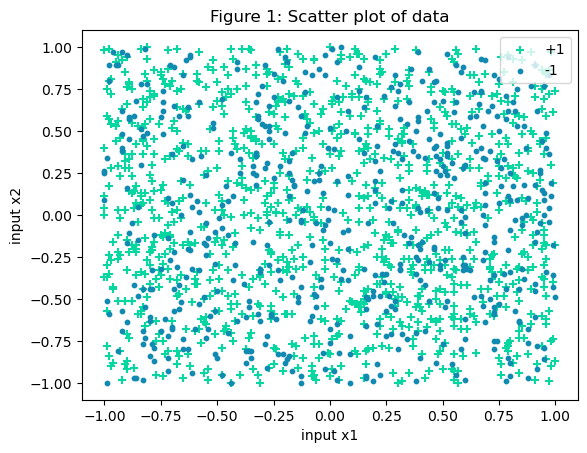

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X1[:, 0], X1[:, 1], marker='+', color='#06d6a0', label='+1')
ax.scatter(X2[:, 0], X2[:, 1], marker='o', color='#118ab2', s=10, label='-1')
ax.set_xlabel('input x1')
ax.set_ylabel('input x2')
ax.legend(loc='best')
plt.title("Figure 1: Scatter plot of data")
plt.show()

### 使用交叉验证对逻辑回归（Logistics）进行特征选取

1. 将数据分为训练集(train)与测试集(test)
2. 将训练集(train)数据使用使用特征工程，选择合适的特征多项式，以及确定合适的C

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=77)

In [7]:
def logi_tune_params(c_list, degree_list, x, y, cv=5):
    colors = ['#06d6a0', '#118ab2', '#ffd166', '#ef476f']
    best_score = 0
    best_c = 0
    
    for i, degree in enumerate(degree_list):
        x_poly = PolynomialFeatures(degree).fit_transform(x)
        accuracy = []
        accuracy_std = []
        for c in c_list:
            model = LogisticRegression(penalty='l2', C=c, solver='lbfgs', max_iter=1000)
            train_score = cross_val_score(model, x_poly, y, cv=cv, scoring='accuracy')
            model.fit(x_poly, y)

            accuracy.append(train_score.mean())
            accuracy_std.append(train_score.std())
            
            curr_score = train_score.mean()
            if curr_score > best_score:
                best_score = curr_score
                best_c = c

        plt.errorbar(c_list, accuracy, yerr=accuracy_std, c=colors[i], label='degree = {}'.format(degree))
    print(best_score, best_c)
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Relationships among Polynomial Degree, C and Accuracy")
    plt.show()

0.65 1


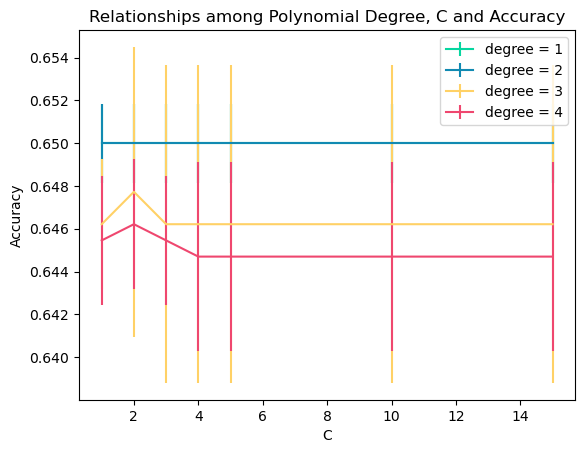

In [8]:
C_range = [1, 2, 3, 4, 5, 10, 15]
degree_range = [1, 2, 3, 4]
logi_tune_params(C_range, degree_range, x_train, y_train)

可以看到，当degree的数值大于2之后，模型的准确度（accuracy）比较高，且稳定。因此degree值选择2可以使模型拟合情况较好，且可以防范出现过拟合的情况。
当C = 5时，准确度此时最大，且已经逐渐趋于稳定，因此选取C=5.

### 使用交叉验证对KNN进行特征选取

In [9]:
def knn_tune_params(k_list, x, y, cv=5):
    accuracy = []
    accuracy_std = []
    best_score = 0
    best_k = 0

    for i, k in enumerate(k_list):
        knn_clf = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn_clf.fit(x, y)

        scores = cross_val_score(knn_clf, x, y, cv=cv, scoring='accuracy')
        accuracy.append(scores.mean())
        accuracy_std.append(scores.std())
        
        curr_score = scores.mean()
        if curr_score > best_score:
            best_score = curr_score
            best_k = k
            
    print(best_score, best_k)
    plt.errorbar(k_list, accuracy, yerr=accuracy_std, c='#06d6a0', label='accuracy')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Relationships between k and Accuracy")
    plt.show()

0.6409090909090909 79


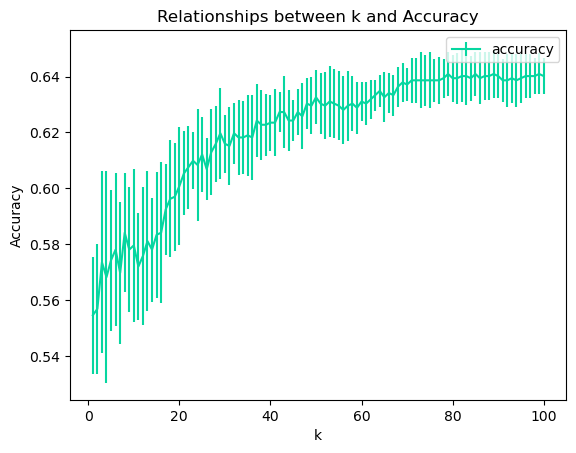

In [15]:
k_range = np.linspace(1, 100, 100, dtype=int)
knn_tune_params(k_range, x_train, y_train)

### 混淆矩阵

In [11]:
# logis
x_logis = PolynomialFeatures(2).fit_transform(x_train)
x_test_logis = PolynomialFeatures(2).fit_transform(x_test)

model_logis = LogisticRegression(penalty='l2', C=5)
model_logis.fit(x_logis, y_train)

y_pred_logis = model_logis.predict(x_test_logis)
mat_logis = confusion_matrix(y_pred_logis, y_test)
print(mat_logis)

# Knn
model_knn = KNeighborsClassifier(n_neighbors=18, weights='distance')
model_knn.fit(x_train, y_train)
y_pred_knn = model_knn.predict(x_test)
mat_knn = confusion_matrix(y_pred_knn, y_test)
print(mat_knn)

model_dummy = DummyClassifier(strategy="most_frequent").fit(x_train, y_train)
y_pred_dummy = model_dummy.predict(x_test)
mat_dummy = confusion_matrix(y_test, y_pred_dummy)
print(mat_dummy)
# print(classification_report(y_test, y_pred_dummy))

[[  0   0]
 [113 217]]
[[ 15  31]
 [ 98 186]]
[[  0 113]
 [  0 217]]


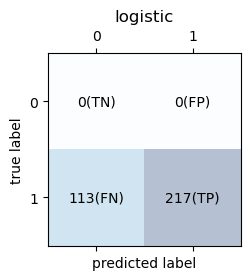

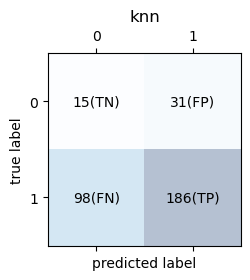

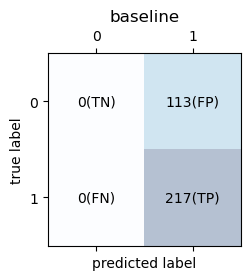

In [20]:
def draw_matrix(confmat, title):
    text_list = ['TN', 'FP', 'FN', "TP"]
    
    fig,ax = plt.subplots(figsize=(2.5,2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
    text_index = 0
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j,y=i,s=str(confmat[i,j]) + str('({})').format(text_list[text_index]),va='center',ha='center')
            text_index += 1
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title(title)
    plt.show()

draw_matrix(mat_logis, 'logistic')
draw_matrix(mat_knn, 'knn')
draw_matrix(mat_dummy, 'baseline')

### ROC曲线

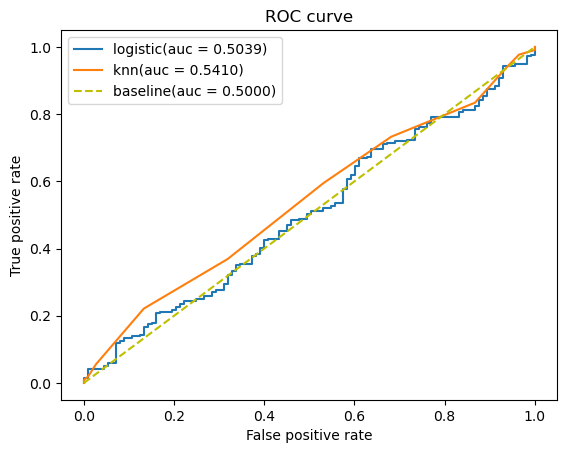

In [21]:
x_logis = PolynomialFeatures(2).fit_transform(x_train)
x_test_logis = PolynomialFeatures(2).fit_transform(x_test)

model_logis = LogisticRegression(penalty='l2', C=5).fit(x_logis, y_train)
fpr1, tpr1, _ = roc_curve(y_test, model_logis.decision_function(x_test_logis))
roc_auc1 = auc(fpr1,tpr1)
plt.plot(fpr1, tpr1, label='logistic(auc = %0.4f)' % (roc_auc1))

model_knn = KNeighborsClassifier(n_neighbors=18, weights='uniform').fit(x_train, y_train)
fpr2, tpr2, _ = roc_curve(y_test, model_knn.predict_proba(x_test)[:, 1])
roc_auc2 = auc(fpr2,tpr2)
plt.plot(fpr2, tpr2, label='knn(auc = %0.4f)' % (roc_auc2))

dummy = DummyClassifier(strategy="most_frequent").fit(x_train, y_train)
fpr3, tpr3, _ = roc_curve(y_test, dummy.predict_proba(x_test)[:, 1])
roc_auc3 = auc(fpr3,tpr3)
plt.plot(fpr3, tpr3, c='y', label='baseline(auc = %0.4f)' % (roc_auc3), linestyle='--')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## dataset 2

In [14]:
# data = np.loadtxt('../03_Code/week4_1.txt', delimiter=',')
# X = data[:, :2]
# Y = data[:, 2]